#  A tutorial for the `general-graphs` library

Here, we demonstrate how to use the `general-graphs` library developed for the creation and manipulation of any linear framework graph. In the development of this software, the NetworkX library for Python 3 was used. For more information on NetworkX, see https://networkx.org/documentation/stable/index.html

In [1]:
import matplotlib.pyplot as plt
from tqdm import tqdm
from general_graph_utils import *

In [2]:
plt.rc("text", usetex=False)
plt.rc("font", family = "serif",size=14)
plt.rc("figure",figsize=(10,8))
%config InlineBackend.figure_format = 'retina'

## 1. Create a general linear framework graph with a random number of nodes and randomly assigned edges.

A linear framework graph $G$ is a finite, directed graph with labeled edges and no self-loops (see I Mirzaev & J Gunawardena 2013 for more details on the linear framework and its equivalence to continuous time finite state Markov processes). Here, we use a linear framework graph to represent a Markovian system, such as biochemical reactions.

To generate a random linear framework graph, you first must decide the maximum number of nodes you want in your graph. Set that number as `n`. Then, define a directed graph `G` and an undirected graph `G_ud` as the outputs of the function `random_graph(n)`. `G` and `G_ud` are graph objects as defined by the NetworkX library.

`random_graph(n)` picks a random number between 3 and `n` to be the size of the graph, adds that many nodes to the graph, and then randomly assigns edges between the nodes such that the resulting graph is strongly connected and fully reversible.

It is necessary to have a directed and undirected version of the graph for the various functions that we will use going forward. Also, to clarify notation, $G$ refers to the mathematical object defined by the linear framework, while `G` and `G_ud` refer to graph objects defined in this numerical simulation using the NetworkX library.

In [3]:
n = 10
G, G_ud = random_graph(n)

In [4]:
print(G)

DiGraph with 9 nodes and 52 edges


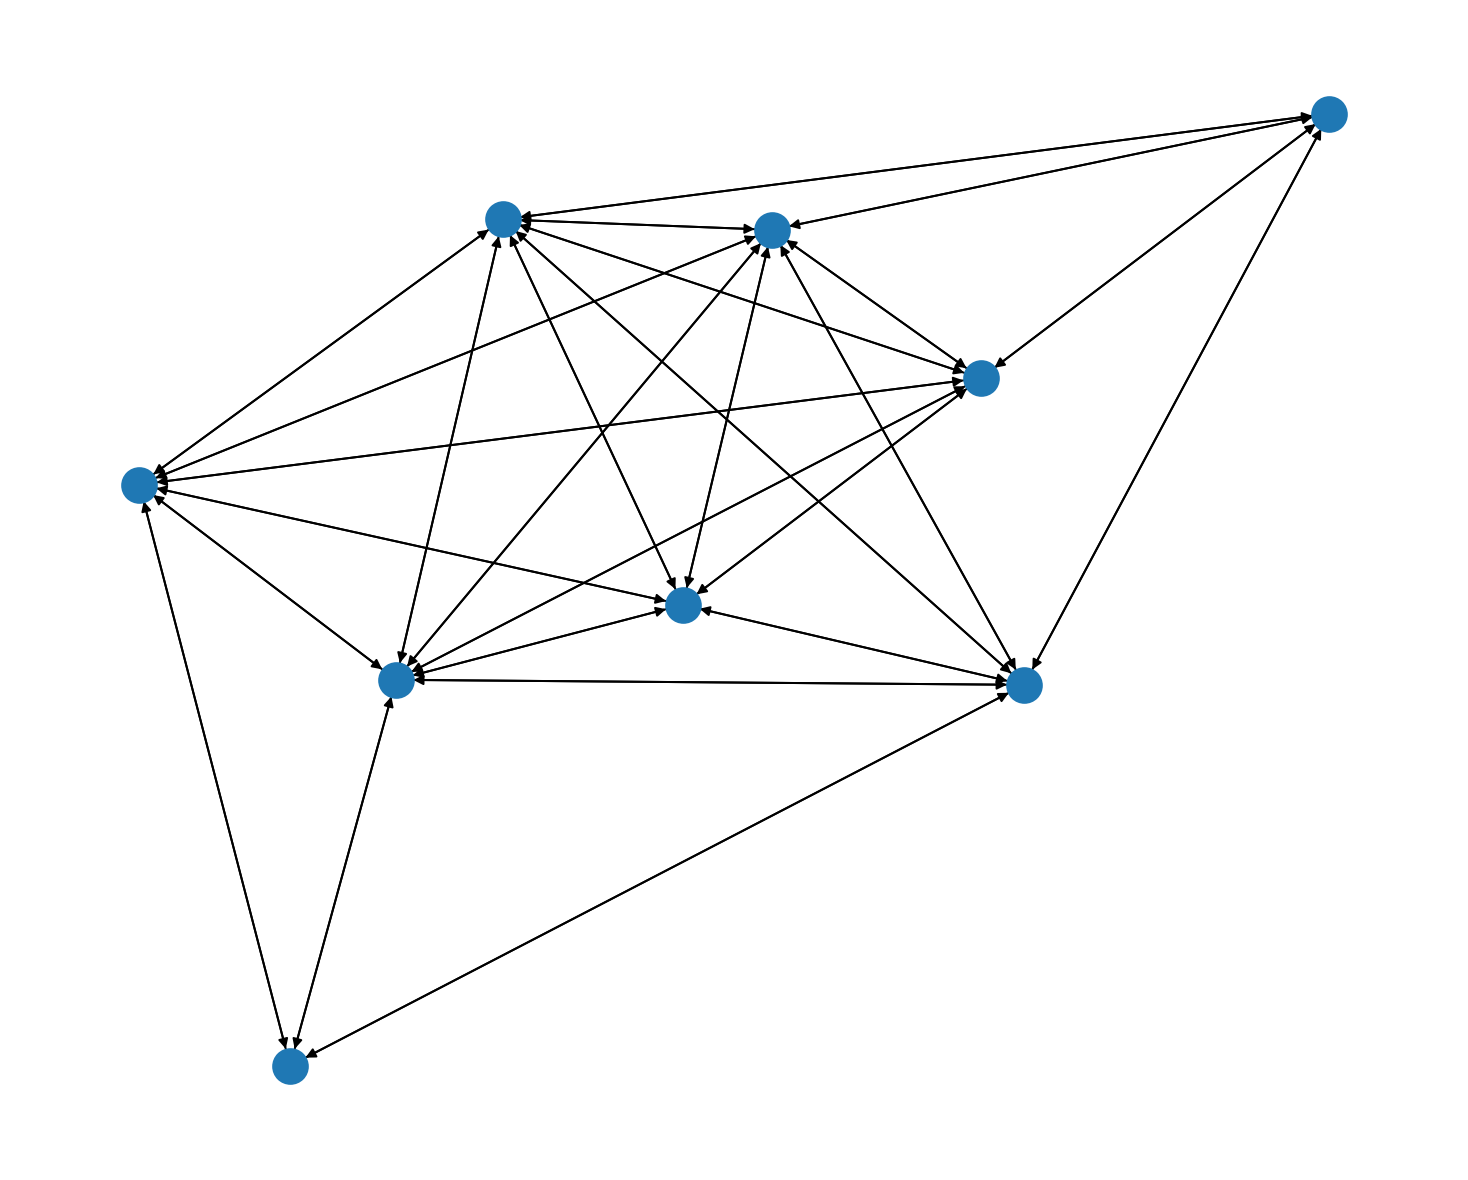

In [5]:
nx.draw(G)

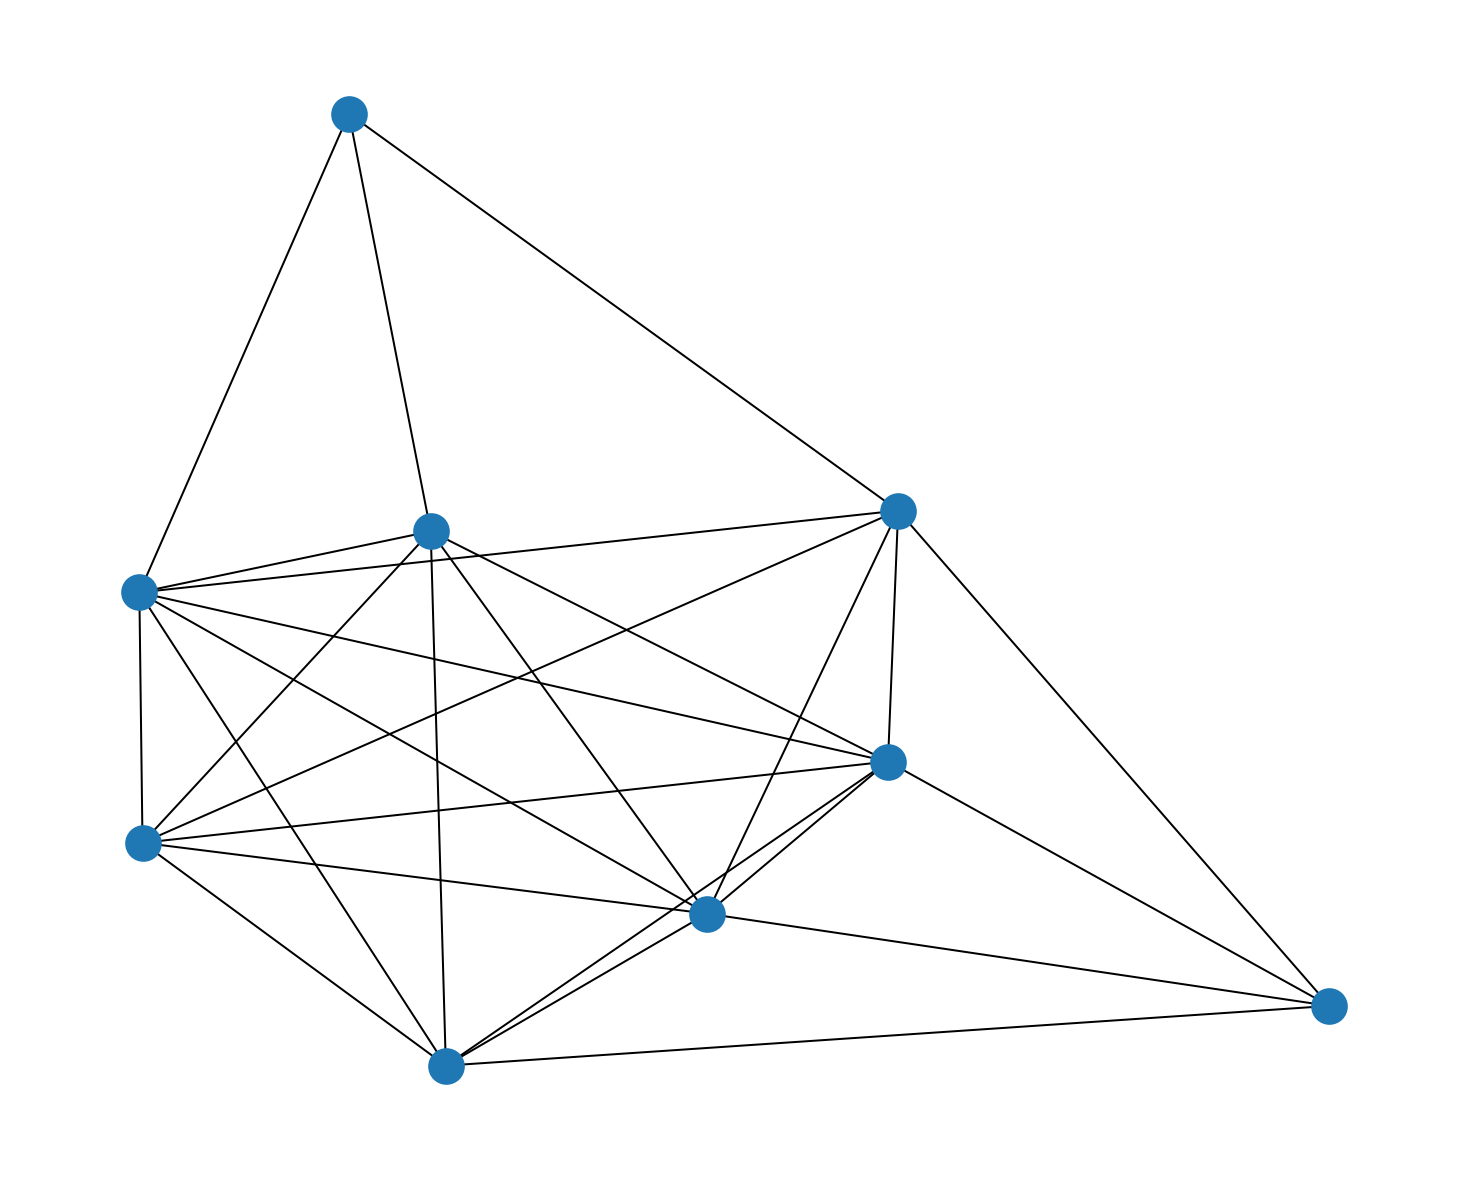

In [6]:
nx.draw(G_ud)

### 1.1. Create data structures containing the graph's structural information.

Next, we will assign structural information from `G` and `G_ud` to specific data structures, which will be necessary to compute quantities such as the cycle affinity.

Let's begin with the nodes and the edges of $G$.

`node_list`: a ***1D NumPy array*** of the nodes in $G$.

In [7]:
node_list = get_nodes(G)
num_nodes = len(node_list)
print(node_list)

[1 2 3 4 5 6 7 8 9]


`edge_list`: a ***1D NumPy array*** of the edges in $G$. Each directed edge $i \to j$ between vertices $i$ and $j$ is represented as a list `[i j]`.

In [8]:
edge_list = get_edges(G)
print(edge_list)

[[1 8]
 [1 2]
 [1 5]
 [1 3]
 [1 4]
 [1 6]
 [1 7]
 [2 4]
 [2 9]
 [2 6]
 [2 7]
 [2 1]
 [2 8]
 [3 4]
 [3 1]
 [3 6]
 [3 5]
 [4 6]
 [4 7]
 [4 1]
 [4 2]
 [4 3]
 [4 8]
 [5 3]
 [5 6]
 [5 1]
 [5 7]
 [5 8]
 [5 9]
 [6 7]
 [6 5]
 [6 8]
 [6 1]
 [6 2]
 [6 3]
 [6 4]
 [7 5]
 [7 9]
 [7 1]
 [7 4]
 [7 2]
 [7 6]
 [7 8]
 [8 7]
 [8 5]
 [8 2]
 [8 6]
 [8 4]
 [8 1]
 [9 5]
 [9 2]
 [9 7]]


Let $C = i \leftrightharpoons 1 \leftrightharpoons 2 \leftrightharpoons \cdots \leftrightharpoons j \leftrightharpoons i$ represent a cycle of reversible edges in a graph. Linear framework graphs can be broken down into cycles (see the work of Terrell Hull and Johannes Schnakenberg for more details on taking a graph theoretic approach to stochastic thermodynamics), which is done by specifying a **cycle basis**.

To define a cycle basis, we take advantage of the NetworkX function `nx.cycle_basis`. More information can be found here: https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.cycles.cycle_basis.html

`cycle_list`: a ***list of lists*** of the nodes involved in each cycle in $G$. Note that `G_ud`, not `G`, is required here.

`num_cycles`: number of cycles in $G$. This will be an essential parameter in later computations.

In [9]:
cycle_list = get_cycle_nodes(G_ud)
num_cycles = len(cycle_list)
print(cycle_list)
print(num_cycles)

[[7, 5, 1], [8, 5, 1], [3, 5, 1], [6, 5, 1], [2, 9, 5, 1], [7, 9, 5], [2, 4, 1], [3, 4, 1], [6, 4, 1], [8, 4, 1], [7, 4, 1], [6, 7, 1], [8, 7, 1], [2, 7, 1], [8, 2, 1], [6, 2, 1], [3, 6, 1], [8, 6, 1]]
18


### 1.2. Specify a parameterization of $G$

To define edge labels for $G$, we use the following algorithm. If G is not already labeled, the labels are logarithmically sampled from the range $[10^{-3},10^3]$. 

The function returns the following data structures.

`label_dict`: a ***dictionary*** matching each edge to its corresponding label. The keys are the edges (listed as a tuple $(i,j)$ for each directed edge $i\to j$ and the values are the associated labels.

`label_list`: a ***1D NumPy array*** containing a list of the labels in $G$. The order is the same as in `edge_list`, which can be confirmed from `label_dict`

In [10]:
label_dict, label_list = get_labels(G)
print(label_dict)
print(label_list)

{(1, 8): 0.00657, (1, 2): 0.00345, (1, 5): 2.01864, (1, 3): 20.80745, (1, 4): 102.12274, (1, 6): 0.01017, (1, 7): 8.72425, (2, 4): 21.0758, (2, 9): 0.00229, (2, 6): 13.60327, (2, 7): 125.17269, (2, 1): 18.01977, (2, 8): 0.2657, (3, 4): 0.72334, (3, 1): 0.32071, (3, 6): 0.01006, (3, 5): 0.00286, (4, 6): 0.0259, (4, 7): 0.00706, (4, 1): 53.92238, (4, 2): 0.00184, (4, 3): 0.3105, (4, 8): 0.04641, (5, 3): 0.00264, (5, 6): 0.05566, (5, 1): 11.90894, (5, 7): 1.09674, (5, 8): 1.59568, (5, 9): 52.71648, (6, 7): 869.12304, (6, 5): 0.00534, (6, 8): 729.96304, (6, 1): 0.00151, (6, 2): 3.62806, (6, 3): 849.60854, (6, 4): 136.78315, (7, 5): 40.07469, (7, 9): 0.00886, (7, 1): 0.15172, (7, 4): 0.02609, (7, 2): 415.33845, (7, 6): 5.4021, (7, 8): 0.76888, (8, 7): 0.03147, (8, 5): 0.00525, (8, 2): 666.76071, (8, 6): 20.22677, (8, 4): 763.13709, (8, 1): 0.04034, (9, 5): 0.00322, (9, 2): 0.11155, (9, 7): 0.02902}
[6.5700000e-03 3.4500000e-03 2.0186400e+00 2.0807450e+01 1.0212274e+02
 1.0170000e-02 8.72425

Going forward, it will be useful to specify which edges (and their corresponding labels) are associated with each cycle and to separate forward and backward traversals of each cycle. The next algorithm generates data structures that separate this information.

`cycle_edges_forward`: a ***list of lists*** where each element is a list of the edges going around one direction ("forward") of a given cycle

`cycle_edges_backward`: a ***list of lists*** where each element is a list of the edges going around the opposite direction ("backward") of a given cycle

`cycle_labels_forward`: a ***list of lists*** where each element is a list of the labels associated with the forward edges

`cycle_labels_backward`: a ***list of lists*** where each element is a list of the labels associated with the backward edges

Note that each of these data structures are ***lists of lists***. The indexing for all of them works as follows.

`cycle_edges_forward[i][j]` refers to edge `j` in cycle `i`. `cycle_labels_forward[i][j]` refers to the label on edge `j` in cycle `i`.

In [11]:
cycle_edges_forward,cycle_edges_backward,cycle_labels_forward,cycle_labels_backward = get_cycle_labels_edges(cycle_list,label_dict)

In [12]:
print(cycle_edges_forward)
print(cycle_edges_backward)

[[(7, 5), (5, 1), (1, 7)], [(8, 5), (5, 1), (1, 8)], [(3, 5), (5, 1), (1, 3)], [(6, 5), (5, 1), (1, 6)], [(2, 9), (9, 5), (5, 1), (1, 2)], [(7, 9), (9, 5), (5, 7)], [(2, 4), (4, 1), (1, 2)], [(3, 4), (4, 1), (1, 3)], [(6, 4), (4, 1), (1, 6)], [(8, 4), (4, 1), (1, 8)], [(7, 4), (4, 1), (1, 7)], [(6, 7), (7, 1), (1, 6)], [(8, 7), (7, 1), (1, 8)], [(2, 7), (7, 1), (1, 2)], [(8, 2), (2, 1), (1, 8)], [(6, 2), (2, 1), (1, 6)], [(3, 6), (6, 1), (1, 3)], [(8, 6), (6, 1), (1, 8)]]
[[(5, 7), (1, 5), (7, 1)], [(5, 8), (1, 5), (8, 1)], [(5, 3), (1, 5), (3, 1)], [(5, 6), (1, 5), (6, 1)], [(9, 2), (5, 9), (1, 5), (2, 1)], [(9, 7), (5, 9), (7, 5)], [(4, 2), (1, 4), (2, 1)], [(4, 3), (1, 4), (3, 1)], [(4, 6), (1, 4), (6, 1)], [(4, 8), (1, 4), (8, 1)], [(4, 7), (1, 4), (7, 1)], [(7, 6), (1, 7), (6, 1)], [(7, 8), (1, 7), (8, 1)], [(7, 2), (1, 7), (2, 1)], [(2, 8), (1, 2), (8, 1)], [(2, 6), (1, 2), (6, 1)], [(6, 3), (1, 6), (3, 1)], [(6, 8), (1, 6), (8, 1)]]


In [13]:
print(cycle_labels_forward)
print(cycle_labels_backward)

[[40.07469, 11.90894, 8.72425], [0.00525, 11.90894, 0.00657], [0.00286, 11.90894, 20.80745], [0.00534, 11.90894, 0.01017], [0.00229, 0.00322, 11.90894, 0.00345], [0.00886, 0.00322, 1.09674], [21.0758, 53.92238, 0.00345], [0.72334, 53.92238, 20.80745], [136.78315, 53.92238, 0.01017], [763.13709, 53.92238, 0.00657], [0.02609, 53.92238, 8.72425], [869.12304, 0.15172, 0.01017], [0.03147, 0.15172, 0.00657], [125.17269, 0.15172, 0.00345], [666.76071, 18.01977, 0.00657], [3.62806, 18.01977, 0.01017], [0.01006, 0.00151, 20.80745], [20.22677, 0.00151, 0.00657]]
[[1.09674, 2.01864, 0.15172], [1.59568, 2.01864, 0.04034], [0.00264, 2.01864, 0.32071], [0.05566, 2.01864, 0.00151], [0.11155, 52.71648, 2.01864, 18.01977], [0.02902, 52.71648, 40.07469], [0.00184, 102.12274, 18.01977], [0.3105, 102.12274, 0.32071], [0.0259, 102.12274, 0.00151], [0.04641, 102.12274, 0.04034], [0.00706, 102.12274, 0.15172], [5.4021, 8.72425, 0.00151], [0.76888, 8.72425, 0.04034], [415.33845, 8.72425, 18.01977], [0.2657, 0

### 1.3. Calculate the cycle affinity for each cycle in the graph

The cycle affinity is a dimensionless quantity that serves as a measure of thermodynamic force (see J Schnakenberg 1986). Mathematically, we define the cycle affinity in the following way. Recall that $C = i \leftrightharpoons 1 \leftrightharpoons 2 \leftrightharpoons \cdots \leftrightharpoons j \leftrightharpoons i$ represents a cycle of reversible edges in a graph. For any cycle $C$, the cycle affinity $\tilde{A}(C)$ is given by

$$ \tilde{A}(C) = \log { \left ( \dfrac{\ell(i\to 1)\ell(1\to 2)\cdots \ell(j \to i)}{\ell(1\to i)\ell(2\to 1)\cdots \ell(i \to j)} \right ) } $$

where $\ell(a \to b)$ is the label on the directed edge $a \to b$. To compute this quantity for each cycle in our graph object `G`, we must complete the following steps.

1. Calculate the products of edge labels in each direction around each cycle.
2. Take the log of the ratio of the forward and backwards products for each cycle

`products_f`: a ***1D NumPy array*** where each element is the product of labels corresponding to the forward traversal of each cycle

`products_b`: a ***1D NumPy array*** where each element is the product of labels corresponding to the backward traversal of each cycle

In [14]:
products_f, products_b = calculate_cycle_products(cycle_labels_forward,cycle_labels_backward)

In [15]:
print(products_f)
print(products_b)

[4.16362283e+03 4.10769113e-04 7.08692767e-01 6.46748332e-04
 3.02958789e-07 3.12891148e-05 3.92077767e+00 8.11578240e+02
 7.50105943e+01 2.70356605e+02 1.22735793e+01 1.34105025e+00
 3.13693086e-05 6.55196418e-02 7.89377264e+01 6.64882125e-01
 3.16077650e-04 2.00663717e-04]
[3.35896433e-01 1.29939314e-01 1.70913081e-03 1.69659829e-04
 2.13906557e+02 6.13075532e+01 3.38602005e+00 1.01694289e+01
 3.99391824e-03 1.91192090e-01 1.09388079e-01 7.11651991e-02
 2.70596740e-01 6.52949334e+04 3.69782661e-05 7.08662351e-05
 2.77110080e+00 2.99473031e-01]


`total_affinities`: a ***1D NumPy array*** where each element is the thermodynamic force for each cycle in the graph, corresponding to their order in cycle_list

In [16]:
total_affinities = calculate_affinities(products_b, products_f, cycle_list)

In [17]:
print(total_affinities)

[ -9.42509325   5.75679152  -6.02743716  -1.33816182  20.37520832
  14.48814334  -0.14663482  -4.37959474  -9.84061188  -7.2542185
  -4.7203023   -2.93620443   9.06255497  13.81207503 -14.57383949
  -9.14657096   9.07876729   7.30814919]


### 1.4 Calculate the Laplacian matrix $L$ and the steady state distribution $\pi$ of $G$

`L`: the Laplacian matrix of the graph

In [18]:
L = Laplacian_all(edge_list, label_list, node_list)
print(L)

[[-8.43653700e+01  3.45000000e-03  2.08074500e+01  1.02122740e+02
   2.01864000e+00  1.01700000e-02  8.72425000e+00  6.57000000e-03
   0.00000000e+00]
 [ 1.80197700e+01 -1.08584406e+03  0.00000000e+00  2.10758000e+01
   0.00000000e+00  1.36032700e+01  1.25172690e+02  2.65700000e-01
   2.29000000e-03]
 [ 3.20710000e-01  0.00000000e+00 -8.70729130e+02  7.23340000e-01
   2.86000000e-03  1.00600000e-02  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 5.39223800e+01  1.84000000e-03  3.10500000e-01 -1.02386821e+03
   0.00000000e+00  2.59000000e-02  7.06000000e-03  4.64100000e-02
   0.00000000e+00]
 [ 1.19089400e+01  0.00000000e+00  2.64000000e-03  0.00000000e+00
  -4.21100000e+01  5.56600000e-02  1.09674000e+00  1.59568000e+00
   5.27164800e+01]
 [ 1.51000000e-03  3.62806000e+00  8.49608540e+02  1.36783150e+02
   5.34000000e-03 -3.93339300e+01  8.69123040e+02  7.29963040e+02
   0.00000000e+00]
 [ 1.51720000e-01  4.15338450e+02  0.00000000e+00  2.60900000e-02
   4.00746900e+01  5.4021000

`pi`: the steady-state distribution of $G$

In [19]:
pi_all = steady_state_spectrum(L)

## 2. Initialize the system at equilibrium

Linear framework graphs represent biochemical systems. The vertices represent components of a system, and edges are treated as chemical reactions under mass-action kinetics with the labels as rate constants (Gunawardena 2012). The dynamics on this system relaxes to a **steady-state** when $dx/dt = 0$, where $x$ is a column vector of component amounts.

Furthermore, we can define two types of steady-states: equilibrium and non-equilibrium. An equilibrium steady-state is characterized by the lack of net fluxes of matter and energy. Detailed balance holds for each pair of reversible edges, and the cycle affinity for each cycle is equal to 0. 

In [20]:
label_dict, label_list = get_labels(G)
print(label_dict)
print(label_list)

{(1, 8): 8.15292, (1, 2): 35.81413, (1, 5): 357.33119, (1, 3): 288.76132, (1, 4): 222.12755, (1, 6): 7.07401, (1, 7): 14.18135, (2, 4): 0.40321, (2, 9): 0.42836, (2, 6): 0.00168, (2, 7): 2.64154, (2, 1): 26.48509, (2, 8): 142.43504, (3, 4): 0.07959, (3, 1): 15.05316, (3, 6): 72.48902, (3, 5): 0.08365, (4, 6): 0.00129, (4, 7): 0.0118, (4, 1): 0.02723, (4, 2): 17.38876, (4, 3): 0.068, (4, 8): 0.02423, (5, 3): 0.54837, (5, 6): 0.08412, (5, 1): 972.24031, (5, 7): 1.10321, (5, 8): 0.20989, (5, 9): 0.0014, (6, 7): 11.95953, (6, 5): 51.1817, (6, 8): 58.8692, (6, 1): 9.43886, (6, 2): 4.70022, (6, 3): 0.00714, (6, 4): 0.00413, (7, 5): 4.10787, (7, 9): 0.06552, (7, 1): 251.89216, (7, 4): 0.07848, (7, 2): 0.02542, (7, 6): 905.32387, (7, 8): 6.30617, (8, 7): 308.00284, (8, 5): 0.0465, (8, 2): 7.0878, (8, 6): 0.53218, (8, 4): 6.72905, (8, 1): 0.05481, (9, 5): 236.7767, (9, 2): 0.01866, (9, 7): 2.75779}
[8.1529200e+00 3.5814130e+01 3.5733119e+02 2.8876132e+02 2.2212755e+02
 7.0740100e+00 1.4181350e+

In [21]:
cycle_edges_forward,cycle_edges_backward,cycle_labels_forward,cycle_labels_backward = get_cycle_labels_edges(cycle_list,label_dict)

In [22]:
cycle_labels_forward, edge_tracker = initial_equilibrium_parameters(cycle_list,cycle_edges_forward,cycle_labels_forward,cycle_labels_backward)

In [23]:
cycle_labels_forward

[[7.201990878615406, 972.24031, 14.181349999999998],
 [0.0005186037717987163, 972.24031, 8.152919999999998],
 [0.010506538329285725, 972.24031, 288.76132],
 [0.04125251600472208, 972.24031, 7.074010000000001],
 [2.9987831460327095e-08, 236.77669999999998, 972.24031, 35.81413],
 [6.07167848371513e-05, 236.7767, 1.10321],
 [104898.782085202, 0.027229999999999997, 35.81413],
 [28.91694155456605, 0.02723, 288.76132],
 [14.04101070950053, 0.02723, 7.07401],
 [1.328785316893639, 0.02723, 8.15292],
 [1709.7549404425815, 0.02723, 14.18135],
 [68.00812031888015, 251.89215999999996, 7.07401],
 [0.002386795555743331, 251.89216, 8.15292],
 [0.0010583407508209647, 251.89216, 35.81413],
 [1.2948409201709703, 26.48509, 8.15292],
 [0.003031210589725398, 26.48509, 7.07401],
 [0.0002789542586785265, 9.43886, 288.76132],
 [0.296606647473824, 9.43886, 8.15292]]

In [24]:
products_f, products_b = calculate_cycle_products(cycle_labels_forward,cycle_labels_backward)
total_affinities = calculate_affinities(products_f, products_b, cycle_list)
print(total_affinities)

[-1.46529924e-16  0.00000000e+00  0.00000000e+00  2.00360561e-16
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.25008510e-16
  1.64148209e-16  1.88217497e-16  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.95481652e-16
  0.00000000e+00  0.00000000e+00]


In [25]:
label_dict, label_list = reformat_labels(cycle_list, cycle_labels_forward, edge_tracker, label_dict, label_list)